# Dependencias

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import tensorflow_text

import numpy as np
import os
import pandas as pd
import re
import json
from gensim.models import Word2Vec
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
SEED = 10103

# Entrenamiento normal con algoritmo genético

In [22]:
class Genetic_model:
    
    def __init__(self,
                 nn_model = "",
                 nlp_model = "",
                 params = "",
                 vector_size = 100,
                 population = 50,
                 min_count = 2,
                 embedding = "https://tfhub.dev/google/nnlm-en-dim50/2",
                 epochs = 32):
        
        self.nn_model = nn_model
        self.nlp_model = nlp_model
        self.parameters = params
        self.vector_size = vector_size
        self.population = population
        self.min_count = min_count
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
        self.metrics_binary = [self.person_score]
        self.loss = tf.keras.losses.categorical_crossentropy
        
        self.indexes = ["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
        self.hub_layer = hub.KerasLayer(embedding, input_shape = [], dtype = tf.string, trainable = False, name = "Embedding")
        
        self.epochs = epochs
        
    def f1(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        
        TP = tf.math.count_nonzero(y_pred * y_true)
        FP = tf.math.count_nonzero(y_pred * (1 - y_true))
        FN = tf.math.count_nonzero((1 - y_pred) * y_true)
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        
        return -2 * precision * recall / (precision + recall)
    
    def person_score(self, y_true, y_pred):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.math.round(y_pred), tf.float32)
        
        f1_binary = self.f1(y_true[ : , 0 : 1], y_pred[ : , 0 : 1])
        
        l = []
        for i in range(1, 5):
            l.append(self.f1(y_true[ : , i : i + 1], y_pred[ : , i : i + 1]))
        
        f1_macro_general = np.mean(l)
        return 0.5 * f1_binary + 0.5 * f1_macro_general
    
    def get_params(self):
        file = open(self.parameters)
        params = json.load(file)
        file.close()
        
        mutation_prob = params["mutation_prob"]
        mutation_importance = params["mutation_importance"]
        
        self.mutation_prob = mutation_prob
        self.mutation_importance = mutation_importance
        
    def pair_two_nn(self, nn_1, nn_2):
        
        self.get_params()

        nn_s = tf.keras.models.clone_model(nn_1)

        layers = [(nn_1.layers[i], nn_2.layers[i]) for i in range(1, len(nn_1.layers))]
        importance = np.random.uniform()

        l = 1
        for l1, l2 in layers:
            if type(l1) is tf.keras.layers.Dense:
                bias = l1.get_weights()[1]

                w1 = l1.get_weights()[0]
                w2 = l2.get_weights()[0]
                b2 = l2.get_weights()[1]
                
                w = importance * w1 + (1 - importance) * w2
                bias = importance * bias + (1 - importance) * b2

                if np.random.uniform() < self.mutation_prob:
                    shape = nn_1.layers[l].get_weights()[0].shape
                    shape_bias = bias.shape
                    w += np.random.normal(size = shape) * self.mutation_importance
                    w /= 1 + self.mutation_importance
                    bias += np.random.normal(size = shape_bias) * self.mutation_importance
                    bias /= 1 + self.mutation_importance

                nn_s.layers[l].set_weights([w, bias])
            l += 1

        nn_s.compile(
            optimizer = self.optimizer,
            loss = tf.keras.losses.BinaryCrossentropy() ,
            metrics = self.metrics_binary
        )

        return nn_s
    
    def preprocess_text(self, text):
        
        text = text.lower()
        text = text.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('ü', 'u')
        text = re.sub(r'http\S+', '', text)
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip(" ")
        return text
    
    def train_nlp_model(self, list_of_files = [], save_model = False, model_name = ""):
        
        data = list(map( lambda x : pd.read_csv(x).rename({"Text" : "text"}, axis = 1)["text"].values.tolist() , list_of_files ))
        
        texts = []
        for i in data:
            texts += i
        
        data = pd.DataFrame({"text" : texts})
        data["text"] = data["text"].apply(lambda x : self.preprocess_text(x))
        data["all_words"] = data["text"].apply(lambda x : self.tokenize(x))
        word2vec = Word2Vec(data["all_words"].values.tolist(), min_count = self.min_count, vector_size = self.vector_size)
        
        self.word2vec = word2vec
        self.vocab = set(list(word2vec.wv.index_to_key))
        
        if save_model:
            word2vec.save(model_name)
        
    def tokenize(self, x): #------------------------------- MEJORAR LA TOKENIZACION --------------------------
        
        return x.strip(" ").split(" ")
    
    def preprocess_dataset(self, dataset, batch_size, size):
        
        AUTOTUNE = tf.data.AUTOTUNE
        dataset = dataset.shuffle(size)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)
        dataset = dataset.cache()
        return dataset
    
    def make_nns(self):
        self.neural_networks = [self.create_nn() for i in range(self.population)]
    
    def train_hate(self, device = "/GPU:0", generations = 100, train = True):
        
        self.get_params()
        counter = 0
        
        with tf.device(device):
            
            self.best_hate_score = 1
            actual_best = 0
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_person_score", patience = 3)]
            while counter < generations:

                X_train_fold, X_val_fold, y_train_fold, y_val_fold = self.k_fold_sets[counter % 10]

                X_train_fold = X_train_fold.copy()
                X_val_fold = X_val_fold.copy()
                
                if train:
                    data_train_tf = tf.data.Dataset.from_tensor_slices((X_train_fold.values.tolist(), y_train_fold[self.indexes].values.tolist()))
                    data_val_tf = tf.data.Dataset.from_tensor_slices((X_val_fold.values.tolist(), y_val_fold[self.indexes].values.tolist()))
                    
                    cache_train = self.preprocess_dataset(data_train_tf, 16, len(data_train_tf))
                    cache_val = self.preprocess_dataset(data_val_tf, 16, len(data_val_tf))
                    
                n = 1
                if not train:
                    clear_output(wait = True)
                    print(f"Generation : {counter} - prob : {self.mutation_prob}, importance : {self.mutation_importance}\nBest score : {self.best_hate_score}\nActual best : {actual_best}")
                self.scores = []
                if train:
                    for neural_network in self.neural_networks:
                        clear_output(wait = True)
                        print(f"Generation : {counter} - prob : {self.mutation_prob}, importance : {self.mutation_importance}\nBest score : {self.best_hate_score}\nActual best : {actual_best}")
                        print(f"Training neural network : {n}")
                        try:
                            neural_network.fit(cache_train, validation_data = cache_val, callbacks = callbacks, epochs = self.epochs)
                        except:
                            neural_network.compile(
                                optimizer = self.optimizer,
                                loss = tf.keras.losses.BinaryCrossentropy() ,
                                metrics = self.metrics_binary
                            )
                            neural_network.fit(cache_train, validation_data = cache_val, callbacks = callbacks, epochs = self.epochs)

                        score = self.person_score(tf.cast(y_val_fold[self.indexes].values.tolist(), tf.float32), tf.cast(neural_network.predict(tf.convert_to_tensor(X_val_fold.values.tolist())), tf.float32))
                        self.scores.append((score, n-1))
                        n += 1
                else:
                    y = y_train_fold[self.indexes].values.tolist()
                    y = np.array(y).reshape((len(y), 2))
                    
                    v = list(map(lambda x : x.tolist(), X_train_fold.values.tolist()))
                    v = tf.convert_to_tensor(v)
                    scores = list(map(lambda x : self.f1_macro(tf.cast(y, tf.float32), tf.cast(x.predict(v), tf.float32)) ,self.neural_networks))
                    self.scores = [(scr, pos) for pos, scr in enumerate(scores)]
                    
                self.scores.sort()
                self.scores.reverse()

                best_model = tf.keras.models.clone_model(self.neural_networks[self.scores[-1][1]])
                second_best_model = tf.keras.models.clone_model(self.neural_networks[self.scores[-2][1]])
                third_bes_model = tf.keras.models.clone_model(self.neural_networks[self.scores[-3][1]])

                if self.best_hate_score > self.scores[-1][0]:
                    self.best_hate_score = self.scores[-1][0]
                    self.best_hate_model = tf.keras.models.clone_model(best_model)


                actual_best = self.scores[-1][0]
                aux = [best_model]

                for i in range(self.population // 2):
                    pos = np.random.choice(range(self.population))
                    aux.append(self.pair_two_nn(best_model, self.neural_networks[pos]))
                for i in range(self.population // 2-1):
                    pos = np.random.choice(range(self.population))
                    aux.append(self.pair_two_nn(second_best_model, self.neural_networks[pos]))
                
                self.neural_networks.clear()
                self.neural_networks = aux.copy()
                del aux

                counter += 1
                
    def k_fold(self, X, y, k, size):
        
        self.k_fold_sets = []
        for i in range(k):
            self.k_fold_sets.append( tuple(train_test_split(X, y, test_size = size)) )
            
    def apply(self, d, t, i):
        
        if i % 2 == 0:
            return np.sin(t * 10000**(i / d))
        return np.cos(t * 10000**((i - 1) / d))

    def positional_encoding(self, d, t):
        
        vector = list(range(0, d))
        vector = list(map(lambda x : self.apply(d, t, x), vector))
        return np.array(vector)

    def phrase_to_vect(self, x):
        
        phrases = self.tokenize(x)
        phrases = [i for i in phrases if i in self.vocab]
        
        return sum(list(map(lambda x : self.word2vec.wv.get_vector(x) * self.positional_encoding(self.vector_size, phrases.index(x)), phrases))).astype(np.float32)
    
    def load_word2vec_model(self):
        self.word2vec = Word2Vec.load(self.nlp_model)
        self.vocab = set(list(self.word2vec.wv.index_to_key))
    
    def load_nnmodel(self):
        self.model_hate = tf.keras.models.load_model(self.nn_model)
        
    def create_nn(self):
        input_layer = tf.keras.Input(shape=(50, ), dtype = tf.float32, name = "input")

        layer_1 = tf.keras.layers.Dense(32, activation = "relu", name = "layer_1", use_bias = True)(input_layer)
        layer_2 = tf.keras.layers.Dense(21, activation = "relu", name = "layer_2", use_bias = True)(layer_1)
        out_1 = tf.keras.layers.Dense(1, activation = "sigmoid", name = "out_1", use_bias = True)(layer_2)
        out_2 = tf.keras.layers.Dense(4, activation = "sigmoid", name = "out_2", use_bias = True)(tf.concat([out_1, layer_2], 1))

        model = tf.keras.Model(inputs = input_layer, outputs = tf.concat([out_1, out_2], 1))
        
        model.compile(
            optimizer = self.optimizer,
            loss = self.loss ,
            metrics = self.metrics_binary
        )

        return model
    
    def attention(self): # ---------------------- TODO ----------------------------
        pass
    
    def set_best_hate_model(self):
        
        self.model_hate = tf.keras.models.clone_model(self.best_hate_model)
        self.model_hate.compile(
            optimizer = self.optimizer,
            loss = tf.keras.losses.BinaryCrossentropy() ,
            metrics = self.metrics_binary
        )
    
    def predict_hate(self, X):
        
        X["text"] = X["text"].apply(lambda x : self.phrase_to_vect(self.preprocess_text(x)))
        return self.model_hate.predict(tf.convert_to_tensor(X["text"].values.tolist()))
    
    def get_new_phrase(self, text):

        word = np.random.choice(self.tokenize(text))
        while word not in self.word2vec.wv.index_to_key:
            word = word = np.random.choice(self.tokenize(text))
        new_word = self.word2vec.wv.most_similar(word)[np.random.choice(range(5))][0]
        return text.replace(word, new_word)
    
    def create_new_data(self, data, size):
        
        return list(map(lambda x : self.get_new_phrase(np.random.choice(data)), range(size)))

## Entrenamos el modelo de Word2vec

In [23]:
files = os.listdir("./Data/")

In [24]:
texts = []
for file in files:
    if "data_found" in file:
        texts.append("./Data/" + file)
        
texts.append("./Data/Spanish Toxicity Dataset.csv")
texts.append("./Data/public_test_data.csv")
texts.append("./Data/referenced_tweets_data.csv")
texts.append("./Data/tweets_train.csv")

In [25]:
Trainer = Genetic_model(params = "./Parameters/parameters.json", nlp_model = "./Model/model", population = 100, vector_size = 100, epochs = 100)

In [26]:
# Trainer.train_nlp_model(texts, True, "./Model/model")
Trainer.load_word2vec_model()

In [27]:
Trainer.word2vec.wv.most_similar("wena")

[('weno', 0.717048168182373),
 ('chistosa', 0.7039027214050293),
 ('charcha', 0.6815004348754883),
 ('fomeee', 0.6788569688796997),
 ('pulento', 0.6730825304985046),
 ('ooooh', 0.6536873579025269),
 ('buta', 0.6492932438850403),
 ('penka', 0.6486002206802368),
 ('youngcis', 0.647746205329895),
 ('uta', 0.6453183889389038)]

## Creamos la red neuronal

### Preparamos los datos

In [28]:
data = pd.read_csv("./Data/tweets_train.csv")
referenced = pd.read_csv("./Data/referenced_tweets_data.csv")[["tweet_id", "conversation_id", "text"]]

In [29]:
data["text"] = data["text"].apply(lambda x : Trainer.preprocess_text(x))
referenced["text"] = referenced["text"].apply(lambda x : Trainer.preprocess_text(x))

In [30]:
transform = {}
for l in referenced.values.tolist():
    tweet_id = l[0]
    conv_id = l[1]
    text_string = l[2]
    
    if conv_id not in transform and conv_id != 0:
        transform[conv_id] = []
    if conv_id != 0:
        transform[conv_id].append((tweet_id, text_string.strip(" ")))
        transform[conv_id].sort()

In [31]:
data = data[["text", "Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]]

In [32]:
data["Odio"] = data["Odio"].apply(lambda x : 1 - int(x == 0))
data["Mujeres"] = data["Mujeres"].apply(lambda x : 1 - int(x == 0))
data["Comunidad LGBTQ+"] = data["Comunidad LGBTQ+"].apply(lambda x : 1 - int(x == 0))
data["Comunidades Migrantes"] = data["Comunidades Migrantes"].apply(lambda x : 1 - int(x == 0))
data["Pueblos Originarios"] = data["Pueblos Originarios"].apply(lambda x : 1 - int(x == 0))

### Data imputation

In [33]:
# number_of_new_data = 1000

# hate_data = data.query("Odio == 1")["text"]
# not_hate_data = data.query("Odio == 0")["text"]

# new_hate_data = Trainer.create_new_data(hate_data.values.tolist(), number_of_new_data)
# new_nohate_data = Trainer.create_new_data(not_hate_data.values.tolist(), number_of_new_data)

# text_column = data["text"].values.tolist() + new_hate_data + new_nohate_data
# hate_column = data["Odio"].values.tolist() + [ 1 for i in range(len(new_hate_data))] + [ 1 for i in range(len(new_nohate_data))]

# full_data = pd.DataFrame({"text" : text_column, "Odio" : hate_column})

### Entrenamos el modelo

In [34]:
X = data["text"].values.tolist()

In [35]:
X_vect = Trainer.hub_layer.call(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_vect), data[["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]], test_size = 0.1)
y_train = y_train.astype(np.float64)

In [37]:
Trainer.k_fold(X_train.copy(), y_train.copy(), 10, 0.1)

In [38]:
Trainer.make_nns()

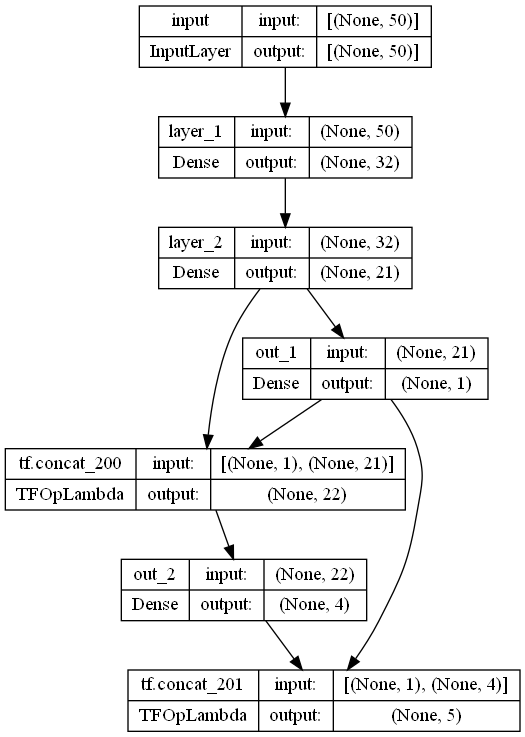

In [39]:
model = Trainer.neural_networks[0]
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [40]:
model.summary()

Model: "model_100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 50)]         0           []                               
                                                                                                  
 layer_1 (Dense)                (None, 32)           1632        ['input[0][0]']                  
                                                                                                  
 layer_2 (Dense)                (None, 21)           693         ['layer_1[0][0]']                
                                                                                                  
 out_1 (Dense)                  (None, 1)            22          ['layer_2[0][0]']                
                                                                                          

In [ ]:
Trainer.train_hate(generations = 15, train = True)

Generation : 0 - prob : 0.35, importance : 0.1
Best score : 1
Actual best : 0
Training neural network : 5
Epoch 1/100
 71/115 [=================>............] - ETA: 1s - loss: 2.1905 - person_score: nan

In [ ]:
Trainer.set_best_hate_model()

# Reuse a trained model

In [ ]:
# embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# hub_layer = hub.KerasLayer(embedding, input_shape = [], dtype = tf.string, trainable = False, name = "Embedding")

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data[["text"]], data[["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]], test_size = 0.1)
# y_train = y_train.astype(np.float64)

In [ ]:
# x_train_tensor = tf.constant(X_train["text"].values.tolist())
# y_train_tensor = tf.constant(y_train[["Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]].values.tolist())

In [ ]:
# text_input = tf.keras.Input(shape=(), dtype = tf.string, name = "Input")

# input_layer = hub_layer(text_input)

# layer_1 = tf.keras.layers.Dense(16, activation = "relu", name = "Layer_1", use_bias = True)(input_layer)
# layer_2 = tf.keras.layers.Dense(10, activation = "relu", name = "Layer_2", use_bias = True)(layer_1)
# out_1 = tf.keras.layers.Dense(1, activation = "sigmoid", name = "Out_1", use_bias = True)(layer_2)
# out_2 = tf.keras.layers.Dense(4, activation = "sigmoid", name = "Out_2", use_bias = True)(tf.concat([out_1, layer_2], 1))

# model = tf.keras.Model(inputs = text_input, outputs = tf.concat([out_1, out_2], 1))

In [ ]:
# model.compile(optimizer = 'adam',
#               loss = tf.keras.losses.categorical_crossentropy,
#               metrics = tf.keras.metrics.CategoricalCrossentropy())

In [ ]:
# callbacks = [tf.keras.callbacks.EarlyStopping("val_loss", patience = 10)]

In [ ]:
# model.fit(x_train_tensor, y_train_tensor, validation_split = 0.1, epochs = 100, callbacks = callbacks)